In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('WindData_Model.csv')

In [3]:
# Independent and dependent features
X = df.iloc[:, 2:]
y = df.iloc[:, 1]
y.head()

0     380.047791
1     447.605713
2     710.587280
3     736.647827
4    1493.807983
Name: Power, dtype: float64

In [4]:
# Important features
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X, y)
print(model.feature_importances_)

[0.79117386 0.20882614]


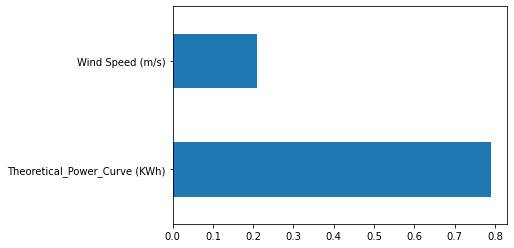

In [5]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [6]:
# Import the necessary packages
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_squared_log_error

In [7]:
# Train/test split method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6737, 2), (1685, 2), (6737,), (1685,))

In [8]:
scaler =  StandardScaler()
# Standardize only continuous features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print(X_train_scaled)

[[-0.6341885  -0.36952123]
 [ 1.54938918  1.35595004]
 [-1.07911859 -1.53841689]
 ...
 [ 1.54525032  1.25123076]
 [ 1.54938918  2.62440002]
 [ 0.92123148  0.57092183]]


In [9]:
# Cross validation method to choose the best train/test 
import math
lin_model = LinearRegression(normalize=False, n_jobs=-1)
lin_model.fit(X_train_scaled, y_train)


cv1 = cross_val_score(lin_model, X_train_scaled, y_train, cv=10)

print(cv1)

[0.90236275 0.89675546 0.89395795 0.92071815 0.92406922 0.90718165
 0.93619003 0.90899442 0.85969519 0.9290244 ]


In [10]:
cv2 = -cross_val_score(lin_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
reg_metric = round(math.sqrt(cv2.mean()),3)

In [11]:
# The new train/test dataframes
x1, x2 = df.iloc[0:4055,2:], df.iloc[5740:,2:]
X_train = pd.concat([x1, x2])
X_test = df.iloc[4055:5740,2:]

y1, y2 = df.iloc[0:4055,1], df.iloc[5740:,1]
y_train = pd.concat([y1, y2])

y_test = df.iloc[4055:5740,1]
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6737, 2), (1685, 2), (6737,), (1685,))

In [12]:
# 1)SVR MODEL

svr_model = SVR()

pipe_svr = Pipeline([('standardizer', scaler), ('regressor', svr_model)])
param_grid_svr ={    'regressor__gamma' : [0.001, 0.01, 0.1],
                     'regressor__C' : [50,60,70] 
                }

grid_svr = GridSearchCV(pipe_svr, param_grid_svr, cv=5, error_score='raise')

grid_svr.fit(X_train,y_train)
preds_svr = grid_svr.predict(X_test)

In [13]:
# 2)Random Forest 
rf_model = RandomForestRegressor(random_state = 0, n_jobs=-1)
param_grid_rf = {'n_estimators': [100, 110, 130, 140]}
                 #'regressor__max_depth': [3, None],
                 #'regressor__max_features': [1, 3, 10],
                 #'regressor__min_samples_split': [2, 3, 10],
                 #'regressor__min_samples_leaf': [1, 3, 10],
                  #'regressor__bootstrap': [True, False]'''


grid_rf = GridSearchCV(estimator = rf_model, param_grid  = param_grid_rf,  cv=5, error_score='raise')

grid_rf.fit(X_train, y_train)
preds_rf1 = grid_rf.predict(X_test)


In [14]:
# 3)XGBoost 
xgb_model = xgb.XGBRegressor(n_jobs = -1)
param_grid_xgb = { 'max_depth':[4,5,6],
                  'n_estimators': [100, 110, 130, 140],
                   'learning_rate': [0.1, 0.5, 0.7]
                    }

grid_xgb = GridSearchCV(estimator = xgb_model, param_grid  = param_grid_xgb,  cv=5, error_score='raise')

grid_xgb.fit(X_train, y_train)
preds_xgb1 = grid_xgb.predict(X_test)

In [15]:
import numpy as np
# 4) RandomForestRegressor with Randomized Search
rf = RandomForestRegressor()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

random_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_rf, scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose = 2, random_state = 42, n_jobs = 1)
rf_random.fit(X_train, y_train)

preds_rf2 = rf_random.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  11.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  11.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  11.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  11.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  11.9s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=  16.4s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   6.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   6.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   6.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   7.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   6.9s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  9.5min finished


In [16]:
# 5)XGBoost with Randomized Search
xgb = xgb.XGBRegressor(n_jobs = -1)
random_grid_xgb = { 'max_depth':[4,5,6],
                  'n_estimators': [100, 110, 130, 140],
                   'learning_rate': [0.1, 0.5, 0.7]
                    }

grid_xgb =  RandomizedSearchCV(estimator = xgb, param_distributions = random_grid_xgb, scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose = 2, random_state = 42, n_jobs = -1)

grid_xgb.fit(X_train, y_train)
preds_xgb2 = grid_xgb.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.0s finished


In [17]:
# Examine the best model
val_svr_metric = math.sqrt(mean_squared_error(y_test, preds_svr))
val_rf_metric = math.sqrt(mean_squared_error(y_test,preds_rf1))
val_xgb_metric = math.sqrt(mean_squared_error(y_test,preds_xgb1))
val_rf_metric2 = math.sqrt(mean_squared_error(y_test, preds_rf2))
val_xgb_metric2 = math.sqrt(mean_squared_error(y_test, preds_xgb2))

In [18]:
models = ['Multiple Linear Regression', 'SVR', 'Random Forest with SearchGrid', 'XGBoost with SearchGrid','Random Forest with RandomizedSearch', 'XGBoost with RandomizedSearch']
val_scores = [reg_metric, val_svr_metric, val_rf_metric, val_xgb_metric, val_rf_metric2, val_xgb_metric2] 
all_models = dict(zip(models, val_scores))
pd.DataFrame.from_dict(all_models,orient='index').rename(columns= {0:'Metric-RMSE'})

,Metric-RMSE
Multiple Linear Regression,398.749000
SVR,215.017982
Random Forest with SearchGrid,351.721174
XGBoost with SearchGrid,214.193829
Random Forest with RandomizedSearch,201.022335
XGBoost with RandomizedSearch,235.725290


In [19]:
val_svr_metric_abs = math.sqrt(mean_absolute_error(y_test, preds_svr))
val_rf_metric_abs = math.sqrt(mean_absolute_error(y_test,preds_rf1))
val_xgb_metric_abs = math.sqrt(mean_absolute_error(y_test,preds_xgb1))
val_rf_metric_abs2 = math.sqrt(mean_absolute_error(y_test, preds_rf2))
val_xgb_metric_abs2 = math.sqrt(mean_absolute_error(y_test, preds_xgb2))

In [20]:
models = ['SVR', 'Random Forest with SearchGrid', 'XGBoost with SearchGrid','Random Forest with RandomizedSearch', 'XGBoost with RandomizedSearch']
val_scores = [val_svr_metric_abs, val_rf_metric_abs, val_xgb_metric_abs, val_rf_metric_abs2, val_xgb_metric_abs2] 
all_models = dict(zip(models, val_scores))
pd.DataFrame.from_dict(all_models,orient='index').rename(columns= {0:'Metric-RMSE'})

,Metric-RMSE
SVR,10.181200
Random Forest with SearchGrid,12.677324
XGBoost with SearchGrid,9.486606
Random Forest with RandomizedSearch,9.399507
XGBoost with RandomizedSearch,9.869527


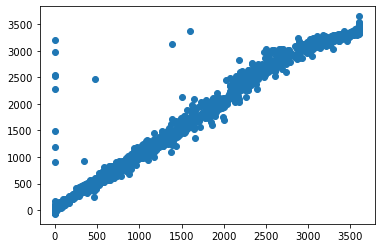

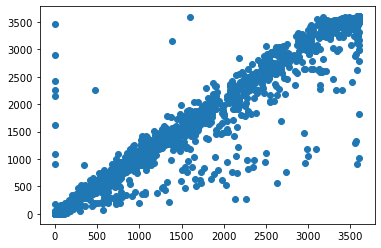

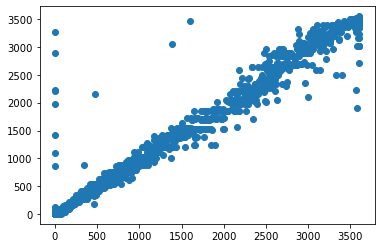

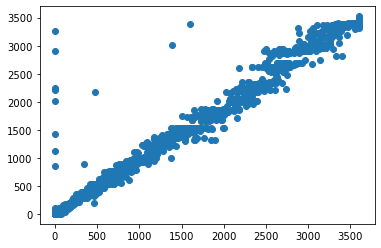

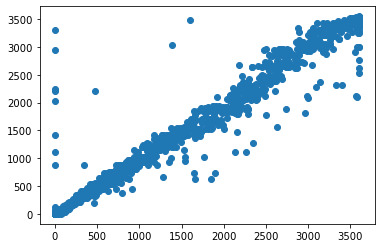

In [21]:
plt.scatter(y_test, preds_svr)
plt.show()
plt.scatter(y_test, preds_rf1)
plt.show()
plt.scatter(y_test, preds_xgb1)
plt.show()
plt.scatter(y_test, preds_rf2)
plt.show()
plt.scatter(y_test, preds_xgb2)
plt.show()

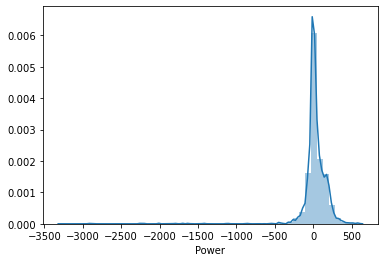

In [22]:
# The best model seems to be the random forest regression model with randomized search 
import seaborn as sns
sns.distplot(y_test-preds_rf2)

In [24]:
# Store the model
import pickle
file = open('Wind_Power_Prediction_Model.pkl', 'wb')
pickle.dump(rf_random, file)